In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

base_path = os.getcwd()

#plt.rcParams.update({'font.size': 10, 'font.family':'Times New Roman'})

#plt.style.use('seaborn')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": 'Times New Roman',
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [10]:
lp_base = os.path.join('..', '..', 'data' 'preprocessed_data')

#lp = lp_base + 'cikk/HTNet_data_03.hdf5'
lp = os.path.join(lp_base, 'HTNet_data', 'HTNet_data.hdf5')


subject_ids = ['EC01', 'EC02', 'EC03', 'EC04', 'EC05', 'EC06', 'EC07', 'EC08', 'EC09', 'EC10',
                    'EC11', 'EC12']

if os.path.isfile(lp):

    preprocessed_data = h5py.File(lp, 'r')

    train_x = preprocessed_data['train_x']
    train_y = preprocessed_data['train_y']
    test_x = preprocessed_data['test_x']
    test_y = preprocessed_data['test_y']

    # calculate SPECTRAL CHANGES for one patient

    id = subject_ids[6]
    print('subject ' + id)

    # get data and labels
    X = np.asarray(train_x[id])
    X = X[:, :64, :]

    # some trials have zeros for all the channels.
    bad_trials = np.unique(np.where(X==0)[0])
    if not len(bad_trials) == 0:
        X = np.delete(X, bad_trials, 0)

    X = np.log(X)
    y = np.asarray(train_y[id])

    # separate rest and movement data
    X_rest = [X[tr,:,:] for tr in range(X.shape[0]) if y[tr] == 1]
    X_rest = np.asarray(X_rest)

    X_move = [X[tr,:,:] for tr in range(X.shape[0]) if y[tr] == 2]
    X_move = np.asarray(X_move)

    # calculate mean
    X_rest_mean = np.mean(X_rest, axis=0)
    X_move_mean = np.mean(X_move, axis=0)

    if not os.path.exists('suppl_data'):
        os.makedirs('suppl_data')
    np.save(os.path.join('suppl_data', 'X_rest_mean.npy'), X_rest_mean)
    np.save(os.path.join('suppl_data', 'X_move_mean.npy'), X_move_mean)
else:
    X_rest_mean = np.load(os.path.join('suppl_data', 'X_rest_mean.npy'))
    X_move_mean = np.load(os.path.join('suppl_data', 'X_move_mean.npy'))

# plot results
nrow = 8
ncol = 8

In [12]:
'''print('subject ' + id)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,10))
# fig.patch.set_facecolor('white')

for i, ax in enumerate(fig.axes):
    print(i)
    diff = X_move_mean[i, :] - X_rest_mean[i, :]
    ax.plot(X_move_mean[i, :], color='b')
    ax.plot(X_rest_mean[i, :], color='r')
    #ax.set_ylim([-1,1])
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('figs/all_spect.png')'''

"print('subject ' + id)\n\nfig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,10))\n# fig.patch.set_facecolor('white')\n\nfor i, ax in enumerate(fig.axes):\n    print(i)\n    diff = X_move_mean[i, :] - X_rest_mean[i, :]\n    ax.plot(X_move_mean[i, :], color='b')\n    ax.plot(X_rest_mean[i, :], color='r')\n    #ax.set_ylim([-1,1])\n    ax.set_yticks([])\n    ax.set_xticks([])\n    plt.savefig('figs/all_spect.png')"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


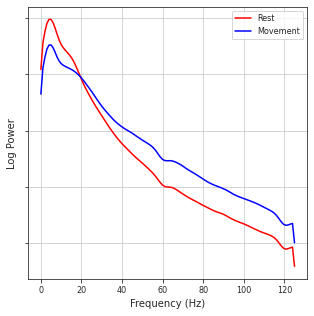

In [13]:
'''fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('white')

plt.plot(X_rest_mean[18, :], color='r', label='Rest')
plt.plot(X_move_mean[18, :], color='b', label='Movement')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.gca().axes.yaxis.set_ticklabels([])  # to hide y values (meaningless in this case)
plt.legend()

#plt.savefig('figs/single_spect.png')'''

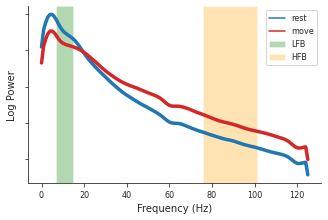

In [14]:
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette())

# create pd dataframe from np arrays
length = len(X_rest_mean[18, :])

ecog_rest = np.column_stack((np.arange(length), X_rest_mean[18, :], ['rest']*length))
ecog_move = np.column_stack((np.arange(length), X_move_mean[18, :], ['move']*length))
ecog = pd.DataFrame(np.concatenate((ecog_rest, ecog_move), 0),
                    columns = ['Frequency (Hz)', 'Log Power', 'event']
                    )
ecog['Frequency (Hz)'] = ecog['Frequency (Hz)'].astype(int)
ecog['Log Power'] = ecog['Log Power'].astype(X_rest_mean[18, 0].dtype)
ecog.sort_values('Frequency (Hz)', inplace=True)

# set background colors
arr = np.ones(len(ecog))
ecog['background'] = arr
for index, row in ecog.iterrows():
    if 7 <= row['Frequency (Hz)'] <= 15:
        ecog.at[index,'background'] = 0
    if 76 <= row['Frequency (Hz)'] <= 101:
        ecog.at[index,'background'] = 2
ecog['background'] = ecog['background'].astype(int).astype(str).map(lambda x: 'C'+x)

# plot lines
fig = plt.figure()
fig.set_size_inches((5.25, 3.2446784409369482))

sns.set_style("ticks")
a = sns.color_palette()
a[1] = a[3]
sns.set_palette(a)
fig = sns.lineplot(data=ecog, x="Frequency (Hz)", y='Log Power', hue='event', linewidth = 3.5)
sns.set_palette(sns.color_palette())
sns.despine()
fig.set(yticklabels=[])

# plot backgrounds
ranges = ecog.groupby('background')['Frequency (Hz)'].agg(['min', 'max'])
ranges = ranges.drop(index='C1')

labels = {'C0':'LFB', 'C2':'HFB'}
colors = {'C0':'green', 'C2':'orange'}

for i, row in ranges.iterrows():
    fig.axvspan(xmin=row['min'], xmax=row['max'], facecolor=colors[i], alpha=0.3, label=labels[i])

fig.legend()

plt.savefig(os.path.join('figs', 'single_spect.png'))


'''#%% calculate LFB HFB

ranges = [range(7, 13), range(10, 14), range(14, 26), range(26, 36), range(36, 70), range(76, 125)]
#ranges = [range(0, 13),  range(36, 70), range(76, 125)]

rest_averaged = [np.mean(X_rest_mean[:,band], axis=1) for band in ranges]
rest_averaged = np.transpose(np.asarray(rest_averaged))
move_averaged = [np.mean(X_move_mean[:,band], axis=1) for band in ranges]
move_averaged = np.transpose(np.asarray(move_averaged))

diff_averaged = np.subtract(rest_averaged, move_averaged)

print('subject ' + id)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,10))
fig.patch.set_facecolor('white')

for i, ax in enumerate(fig.axes):
    for r, band in enumerate(ranges):
        if np.abs(diff_averaged[i, r]) > 0:
            ax.bar(r, diff_averaged[i, r])
    ax.set_ylim([-1,1])
    ax.set_xlim([-1,len(ranges)])

subject EC07


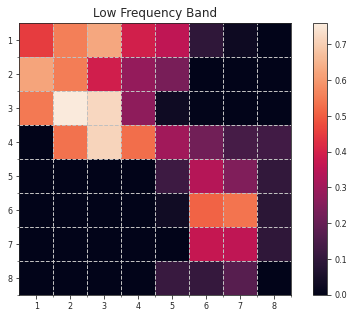

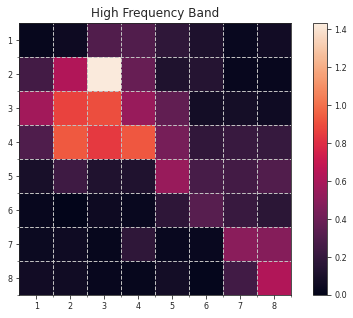

subject EC07


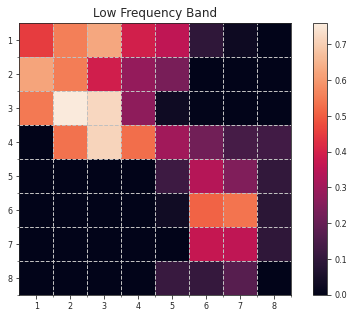

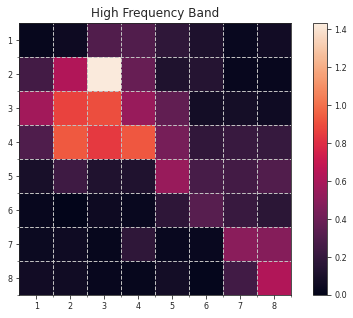

In [16]:
def custom_plot(data, title):
    fig = plt.figure(figsize=(8,5))
    #fig.patch.set_facecolor('white')
    plt.imshow(data, vmin = 0, vmax = np.max(data))

    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, 8, 1))
    ax.set_yticks(np.arange(0, 8, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 8+1, 1))
    ax.set_yticklabels(np.arange(1, 8+1, 1))

    # Minor ticks
    ax.set_xticks(np.arange(.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(.5, 8, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='silver', linestyle='--', linewidth=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

lfb_diff = diff_averaged[:,0].reshape(8, 8)
hfb_diff = diff_averaged[:,-1].reshape(8, 8)

print('subject ' + id)

custom_plot(lfb_diff, 'Low Frequency Band')
custom_plot(np.abs(hfb_diff), 'High Frequency Band')
'''